# Forecasting the Sales of a Supermarket During a Festive Season

## Problem

* A supermarket has various departments, and it must stock up items that will be in demand in each of these departments. However, while stocking up, it must make sure that it does not have excessive stock, which it will not be able to ship out. Hence, you should be able to predict the impact of a festival season on the department-wise sales of a supermarket

* We aim at answering two questions
    * Was Christmas the time when the stores mark the highest numbers in sales?
    * Which departments need to stockup more items to meet the rising demand?

## Solution Overview

* We use the dataset provided by [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data) challenge. Walmart is a famous retail corporation. In this challenge, Walmart has provided historical sales data for 45 Walmart stores located in different regions. Each store contains a number of departments.

* Our main business objectives are to answer two questions stated in the Problem section.
    * For the first question, we will look at the historical data provided and check whether the inclusion of Christmas in a week soars the sales in stores? 
    * For the second questions, in order to point out which departments need to stock up more items to meet the rising demand on Christmas, we will build a model to predict the sales for the next Christmas based on provided historical data. The decision makers will rely on the predicted value and the current number of stocked items to make a decision about how much should they stock up.

* The solution comprises of two parts. The first part deals with data preprocessing, in which we will explore the dataset and clean it for our purpose. The second part tries to build a model to predict the weekly sales for the next Christmas.

## Import Libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import types
from pyspark.sql.functions import col
from pyspark.sql.functions import date_format

from datetime import datetime
from datetime import date

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
# ignore warnings
warnings.filterwarnings("ignore")

In [4]:
spark = (SparkSession.builder
         .appName("Business Intelligence Capstone")
         .master("local[*]")
         .getOrCreate())

23/02/22 19:40:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Part I: Data Cleaning

* The first step is to clean the dataset. We start by loading the dataset then joining the tables in the dataset to get a full-feature table. After that, we look at different fields in the table to spot the illegal values and the relationships between features.

### Loading Data

* Load the Stores

In [5]:
store_schema = types.StructType([
  types.StructField("Store", types.IntegerType(), nullable=False),
  types.StructField("Type", types.StringType(), nullable=False),
  types.StructField("Size", types.IntegerType(), nullable=False)
])


store_df = (spark.read
            .option("header", "true")
            .option("schema", store_schema)
            .csv("../data/stores.csv")
            .withColumnRenamed("Store", "store")
            .withColumnRenamed("Type", "type")
            .withColumnRenamed("Size", "size"))

In [6]:
store_df.show(5)

+-----+----+------+
|store|type|  size|
+-----+----+------+
|    1|   A|151315|
|    2|   A|202307|
|    3|   B| 37392|
|    4|   A|205863|
|    5|   B| 34875|
+-----+----+------+
only showing top 5 rows



In [7]:
store_df.createOrReplaceTempView("stores")

* Load the Train and Features Dataset

In [8]:
%%time

train_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv("../data/train.csv")
            .select(
              col("Store").cast(types.IntegerType()).alias("store"),
              col("Dept").cast(types.IntegerType()).alias("dept"),
              col("Date").cast(types.DateType()).alias("date"),
              col("Weekly_Sales").alias("weekly_sales"),
              col("IsHoliday").alias("is_holiday")
            ))

CPU times: user 5.73 ms, sys: 1.32 ms, total: 7.05 ms
Wall time: 817 ms


In [9]:
train_df.show(5)

+-----+----+----------+------------+----------+
|store|dept|      date|weekly_sales|is_holiday|
+-----+----+----------+------------+----------+
|    1|   1|2010-02-05|     24924.5|     false|
|    1|   1|2010-02-12|    46039.49|      true|
|    1|   1|2010-02-19|    41595.55|     false|
|    1|   1|2010-02-26|    19403.54|     false|
|    1|   1|2010-03-05|     21827.9|     false|
+-----+----+----------+------------+----------+
only showing top 5 rows



In [10]:
train_df.createOrReplaceTempView("train")

In [11]:
features_df = (spark.read
               .option("header", "true")
               .option("inferSchema", "true")
               .csv("../data/features.csv")
               .select(
                 col("Store").cast(types.IntegerType()).alias("store"),
                 col("Date").cast(types.DateType()).alias("date"),
                 col("Temperature").alias("temperature"),
                 col("Fuel_Price").alias("fuel_price"),
                 col("MarkDown1").cast(types.DoubleType()).alias("markdown_1"),
                 col("MarkDown2").cast(types.DoubleType()).alias("markdown_2"),
                 col("MarkDown3").cast(types.DoubleType()).alias("markdown_3"),
                 col("MarkDown4").cast(types.DoubleType()).alias("markdown_4"),
                 col("MarkDown5").cast(types.DoubleType()).alias("markdown_5"),
                 col("CPI").alias("cpi"),
                 col("Unemployment").cast(types.DoubleType()).alias("unemployment"),
                 col("IsHoliday").alias("is_holiday")))

In [12]:
features_df.createOrReplaceTempView("features")

In [13]:
features_df.show(5)

+-----+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+------------+----------+
|store|      date|temperature|fuel_price|markdown_1|markdown_2|markdown_3|markdown_4|markdown_5|        cpi|unemployment|is_holiday|
+-----+----------+-----------+----------+----------+----------+----------+----------+----------+-----------+------------+----------+
|    1|2010-02-05|      42.31|     2.572|      null|      null|      null|      null|      null|211.0963582|       8.106|     false|
|    1|2010-02-12|      38.51|     2.548|      null|      null|      null|      null|      null|211.2421698|       8.106|      true|
|    1|2010-02-19|      39.93|     2.514|      null|      null|      null|      null|      null|211.2891429|       8.106|     false|
|    1|2010-02-26|      46.63|     2.561|      null|      null|      null|      null|      null|211.3196429|       8.106|     false|
|    1|2010-03-05|       46.5|     2.625|      null|      null|      

### Joining Tables

* Merge `train` with `features` and `stores`

In [14]:
train_features = spark.sql(
  """
  select t.store, t.dept, 
         t.date, t.weekly_sales,
         s.type, s.size,
         f.temperature, f.fuel_price, 
         f.markdown_1, f.markdown_2, f.markdown_3, f.markdown_4, f.markdown_5,
         f.cpi, f.unemployment, f.is_holiday
  from train t, features f, stores s
  where (t.store = f.store and t.date = f.date and t.store = s.store)
  """).cache()

In [15]:
train_features.createOrReplaceTempView("train_features")

### Store & Department

In [16]:
spark.sql(
  """
  select count(distinct store) as num_distinct_stores,
         min(store) as min_store_id,
         max(store) as max_store_id
  from train_features
  """
).show()

[Stage 10:==============>                                           (1 + 3) / 4]

+-------------------+------------+------------+
|num_distinct_stores|min_store_id|max_store_id|
+-------------------+------------+------------+
|                 45|           1|          45|
+-------------------+------------+------------+



* There are 45 distinct stores with id range is from 1 to 45.

In [17]:
spark.sql(
  """
  select count(distinct dept) as num_distinct_depts, 
         min(dept) as min_dept_id, 
         max(dept) as max_dept_id
  from train_features
  """
).show()

+------------------+-----------+-----------+
|num_distinct_depts|min_dept_id|max_dept_id|
+------------------+-----------+-----------+
|                81|          1|         99|
+------------------+-----------+-----------+



* There are 81 distinct departments with id range is from 1 to 99 (inclusive). It suggests that some numbers are missing.

### Weekly Sales

In [18]:
spark.sql(
  """
  select min(weekly_sales) as min_sales, max(weekly_sales) as max_sales, mean(weekly_sales) as mean_sales, stddev(weekly_sales) as std_sales
  from train_features
  """
).show()

+---------+---------+------------------+-----------------+
|min_sales|max_sales|        mean_sales|        std_sales|
+---------+---------+------------------+-----------------+
| -4988.94|693099.36|15981.258123467413|22711.18351916329|
+---------+---------+------------------+-----------------+



* The minimum weekly sales is negative, so it suggests that the dataset contains illegal weekly sales values (i.e. non-positive values).

In [19]:
spark.sql(
  """
  select sum(case when weekly_sales <= 0 then 1 else 0 end) as num_illegal_rows,
         count(1) as num_rows
  from train_features
  """).show()

+----------------+--------+
|num_illegal_rows|num_rows|
+----------------+--------+
|            1358|  421570|
+----------------+--------+



* There are 1358 rows with non-positive sale values in 421570 total rows, which is approximately 0.3% ~ a tiny proportion of the dataset. So we can ignore these illegal rows.

In [20]:
train_features = spark.sql(
  """
  select *
  from train_features
  where weekly_sales > 0
  """).cache()

train_features.createOrReplaceTempView("train_features")

### Datetime

In [21]:
spark.sql(
  """
  select min(date) as min_date, max(date) as max_date
  from train_features
  """
).show()

[Stage 22:==============>                                           (1 + 3) / 4]

+----------+----------+
|  min_date|  max_date|
+----------+----------+
|2010-02-05|2012-10-26|
+----------+----------+



In [22]:
spark.sql(
  """
  select distinct date_format(date, "EEEE") as day_of_week
  from train_features
  """
).show()

+-----------+
|day_of_week|
+-----------+
|     Friday|
+-----------+



* The train dataset consists of sales data from 05/02/2010 to 26/10/2012.

* The `date` field does not represent the day, but the friday of every week in a year. We will create two field `year` and `week` to fit the problem better.

In [23]:
train_features = (train_features
                  .withColumn("year", date_format(col("date"), "y"))
                  .withColumn("week", date_format(col("date"), "w")))

In [24]:
train_features.createOrReplaceTempView("train_features")

* Next, we will have to mark Christmas weeks (a Christmas week is a week containing the Christmas day). Christmas is always on December 25th so we will mark the week containing `2010-12-25`, `2011-12-25`, `2012-12-25` days as Christmas.

In [25]:
print("year=2010, week={}".format(date(2010, 12, 25).isocalendar()[1]))
print("year=2011, week={}".format(date(2011, 12, 25).isocalendar()[1]))
print("year=2012, week={}".format(date(2012, 12, 25).isocalendar()[1]))

year=2010, week=51
year=2011, week=51
year=2012, week=52


In [26]:
train_features = spark.sql(
  """
  select *,
         case when year = 2010 and week = 51 then true
              when year = 2011 and week = 51 then true
              when year = 2012 and week = 52 then true
              else false
         end as is_christmas
  from train_features
  """)

In [27]:
train_features.createOrReplaceTempView("train_features")

In [28]:
spark.sql(
  """
  select sum(case when is_christmas then 1 else 0 end) as num_christmas_rows,
         count(1) as num_rows
  from train_features
  """
).show()

[Stage 36:==============>                                           (1 + 3) / 4]

+------------------+--------+
|num_christmas_rows|num_rows|
+------------------+--------+
|              5953|  420212|
+------------------+--------+



* There are 5953 rows of 420212 rows (approximately 1.4%) represents data for Christmas.

### Was Christmas the time when the stores mark the highest numbers in sales?

* We attempt to answer the question about whether Christmas the time when Walmart stores mark the highest numbers in sales.

* We calculate the average numbers in sales per week for all departments of stores and check whether it pumps in the Christmas week. To represent the `average` in this context, we choose median as the metric because it is less affected by outliers.

In [29]:
weekly_sales = spark.sql(
  """
  select year, week, 
         avg(weekly_sales) as mean_sales,
         percentile_approx(weekly_sales, 0.5) as median_sales
  from train_features
  group by year, week
  order by year, week
  """
)

In [30]:
weekly_sales_df = weekly_sales.toPandas()

In [31]:
weekly_sales_df["year"] = weekly_sales_df["year"].astype(np.int32)
weekly_sales_df["week"] = weekly_sales_df["week"].astype(np.int32)

In [32]:
weekly_sales_2010 = weekly_sales_df[weekly_sales_df["year"] == 2010].sort_values("week")
weekly_sales_2011 = weekly_sales_df[weekly_sales_df["year"] == 2011].sort_values("week")
weekly_sales_2012 = weekly_sales_df[weekly_sales_df["year"] == 2012].sort_values("week")

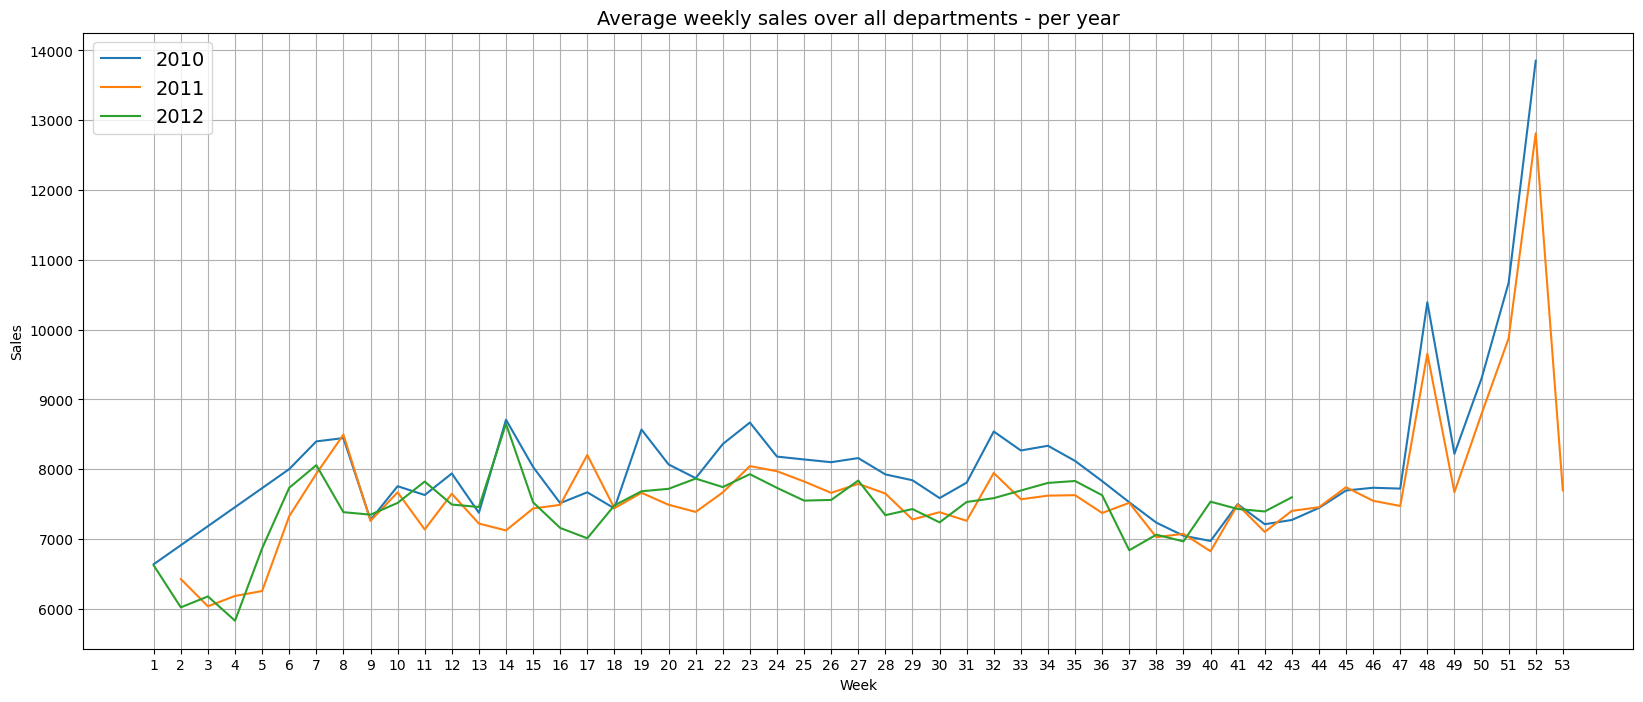

In [33]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

line_2010, = ax.plot(weekly_sales_2010["week"], weekly_sales_2010["median_sales"], label="2010")
line_2011, = ax.plot(weekly_sales_2011["week"], weekly_sales_2011["median_sales"], label="2011")
line_2012, = ax.plot(weekly_sales_2012["week"], weekly_sales_2012["median_sales"], label="2012")

ax.grid()
ax.set_xticks(np.arange(1, 54))
ax.legend(handles=[line_2010, line_2011, line_2012], loc="best", fontsize=14)
ax.set_title("Average weekly sales over all departments - per year", fontsize=14)
ax.set(xlabel="Week", ylabel="Sales")

plt.savefig("median_sales.png")
plt.show()

* Next, we plot the average total sales per store.

In [34]:
weekly_sales_by_store = spark.sql(
  """
  with T as (
    select year, week, store, sum(weekly_sales) as total_sales
    from train_features
    group by year, week, store
    order by year, week, store
  ) 
  select year, week, percentile_approx(total_sales, 0.5) as median_total_sales
  from T
  group by year, week
  order by year, week
  """
)

In [35]:
weekly_sales_by_store_df = weekly_sales_by_store.toPandas()

In [36]:
weekly_sales_by_store_df["year"] = weekly_sales_by_store_df["year"].astype(np.int32)
weekly_sales_by_store_df["week"] = weekly_sales_by_store_df["week"].astype(np.int32)

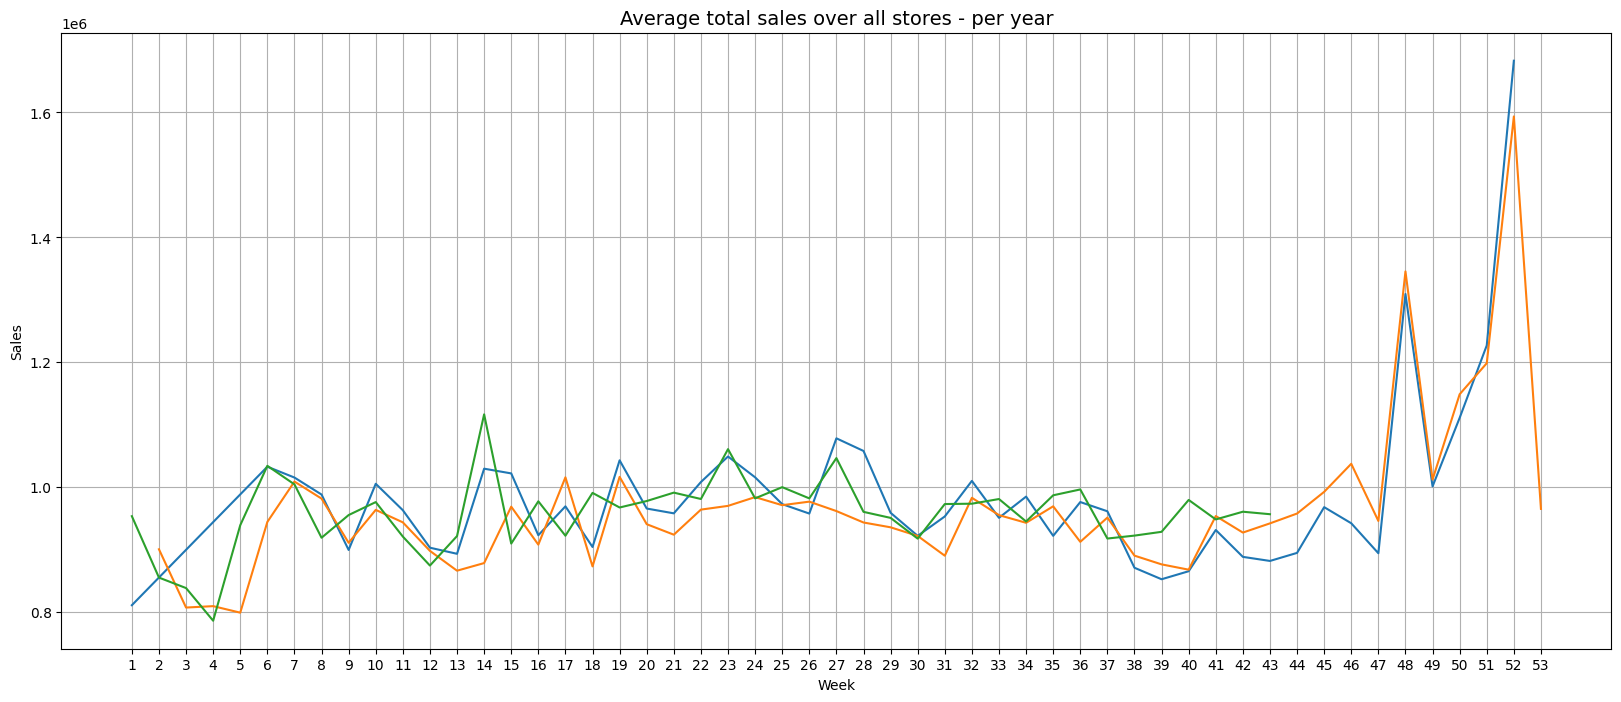

In [37]:
fig = plt.figure(figsize=(20, 8))
ax = fig.gca()

_weekly_sales_2010 = weekly_sales_by_store_df[(weekly_sales_by_store_df["year"] == 2010)].sort_values("week")
_weekly_sales_2011 = weekly_sales_by_store_df[(weekly_sales_by_store_df["year"] == 2011)].sort_values("week")
_weekly_sales_2012 = weekly_sales_by_store_df[(weekly_sales_by_store_df["year"] == 2012)].sort_values("week")
_line_2010, = ax.plot(_weekly_sales_2010["week"], _weekly_sales_2010["median_total_sales"], label="2010")
_line_2011, = ax.plot(_weekly_sales_2011["week"], _weekly_sales_2011["median_total_sales"], label="2011")
_line_2012, = ax.plot(_weekly_sales_2012["week"], _weekly_sales_2012["median_total_sales"], label="2012")

ax.grid()
ax.set_xticks(np.arange(1, 54))
ax.set_title("Average total sales over all stores - per year", fontsize=14)
ax.set(xlabel="Week", ylabel="Sales")

plt.savefig("median_total_sales.png")
plt.show()

* As can be seen from the above line charts, sales rocketed during Christmas in 2010 and 2011. It suggests during the time of Christmas, the stores mark the highest number in sales.

### Type-Size Relationship

* Each store is tagged with a type of A/B/C and a size number. We assume that there is a relationship between them.

In [38]:
type_size_df = spark.sql(
  """
  select type, size
  from train_features
  """).toPandas()

In [39]:
type_size_df["size"] = type_size_df["size"].astype(np.float32)

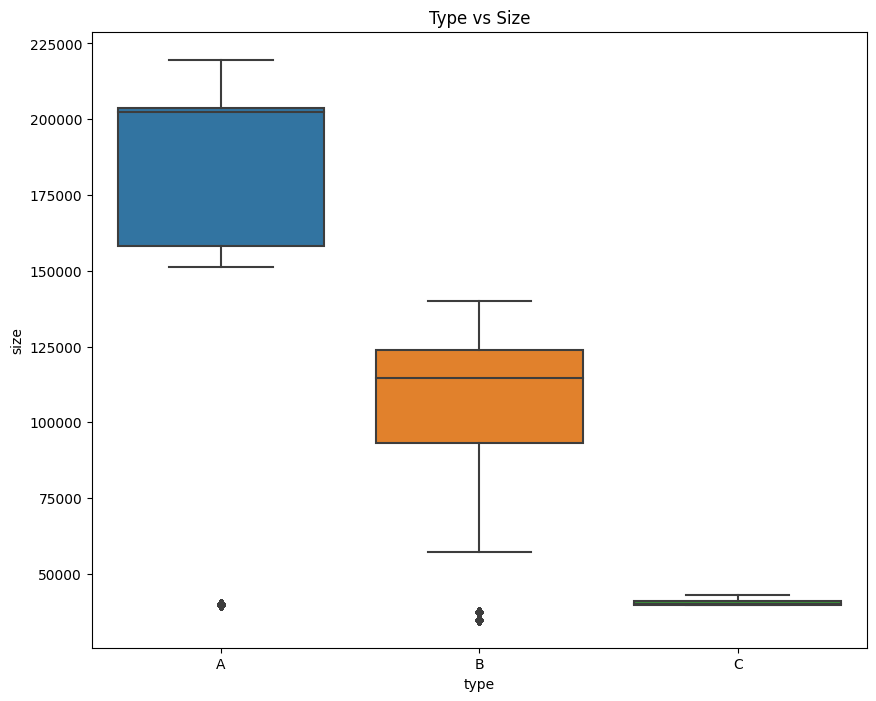

In [40]:
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()
sns.boxplot(x="type", y="size", data=type_size_df, ax=ax)
ax.set_title("Type vs Size")
plt.show()

* As can be seen from the box plot, the types are sorted by descending order of sizes.

### Markdown Columns

* In retail, a markdown is a permanent price decrease for a product at the end of its lifecycle. Markdowns are used to temporarily increase demand for low-demand products, ideally long enough to sell through all stock.

* Walmart gave markdown to see whether it has any effects on sales. The `markdown_*` features contain a lot of null values. We decide to fill them with 0.

In [41]:
spark.sql(
  """
  select 'markdown_1' as feature,
         sum(case when markdown_1 is null then 1 else 0 end) as null_count,
         sum(case when markdown_1 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_2' as feature,
         sum(case when markdown_2 is null then 1 else 0 end) as null_count,
         sum(case when markdown_2 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_3' as feature,
         sum(case when markdown_3 is null then 1 else 0 end) as null_count,
         sum(case when markdown_3 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_4' as feature,
         sum(case when markdown_4 is null then 1 else 0 end) as null_count,
         sum(case when markdown_4 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  union all
  select 'markdown_5' as feature,
         sum(case when markdown_5 is null then 1 else 0 end) as null_count,
         sum(case when markdown_5 is null then 1 else 0 end) / count(1) as null_pct
  from train_features
  """).show()

[Stage 67:=>  (1 + 3) / 4][Stage 68:=>  (1 + 3) / 4][Stage 69:=>  (1 + 3) / 4]

+----------+----------+------------------+
|   feature|null_count|          null_pct|
+----------+----------+------------------+
|markdown_1|    270031|0.6426065890550484|
|markdown_2|    309308|0.7360760758855054|
|markdown_3|    283561|0.6748046224286789|
|markdown_4|    285694|0.6798806316811514|
|markdown_5|    269283|0.6408265351774819|
+----------+----------+------------------+



In [42]:
train_features = train_features.fillna(0, subset=["markdown_1", "markdown_2", "markdown_3", "markdown_4", "markdown_5"])

### Save the Cleaned Dataset

In [43]:
(train_features.repartition(1)
 .write
 .option("header", "true")
 .csv("../data/train_cleaned.csv"))

AnalysisException: 'path file:/home/hungnd61/tmp/msc-business-intelligence/capstone-project/data/train_cleaned.csv already exists.;'

## Part 2: Modeling

* In this part, we will build a machine learning model to predict the sales for each department in Christmas season of 2012 given the historical data of 2010 and 2011. To be more specific, for each department in a store, the model will predict its `weekly_sales` for Christmas in 2012 given their sales data in 2010, 2011 and the early 2012.

### Modeling using both temporal and spatial features

#### Dimensionality Reduction

* For the modeling part, we will perform dimensionality reduction to discard features not meaningful for training our model.

In [ ]:
train_df = train_features.toPandas()

In [ ]:
train_df["year"] = train_df["year"].astype(np.int32)
train_df["week"] = train_df["week"].astype(np.int32)
train_df["cpi"] = train_df["cpi"].astype(np.float32)

In [ ]:
train_df["is_holiday"] = train_df["is_holiday"].astype(np.int32)

In [ ]:
train_df["is_christmas"] = train_df["is_christmas"].astype(np.int32)

In [ ]:
# replace the type of stores from A, B, C to 3, 2, 1 (preserve the size order)
train_df["type"] = train_df["type"].map({"A": 3, "B": 2, "C": 1})

In [ ]:
train_df["size"] = train_df["size"].astype(np.float32)

In [ ]:
train_df["date"] = pd.to_datetime(train_df["date"])

In [ ]:
train_df = (train_df.sort_values("date", ascending=True)
            .reset_index(drop=True))

In [ ]:
fig = plt.figure(figsize=(14, 12))
ax = fig.gca()
sns.heatmap(train_df.corr().abs(), ax=ax)
ax.set_title("Feature Correlation")

plt.savefig("feature_correlation.png")
plt.show()

* We will drop 6 features: `markdown_4`, `markdown_5`, `fuel_price`, `temperature`, `cpi` and `unemployment`
  * It seems that `markdown_4` and `markdown_5` are highly correlated with `markdown_1`.
  * It seems that there no correlation between `fuel_price`/`temperature`/`cpi`/`unemployment` and `weekly_sales`.

#### Train/Test Split

* We will split the dataset into train and test datasets.
  * Sort the date range by ascending order.
  * The train data contains data for 80% of the date range (since the start).
  * The test data contains data for 20% remaining days of the date range.
* Remember that we don't need to 

In [ ]:
feature_cols = ["store", "dept", "year", "week", "type", "size", "is_holiday", "markdown_1", "markdown_2", "markdown_3", "is_christmas"]
target_col = ["weekly_sales"]

In [ ]:
X = train_df[feature_cols]
y = train_df[target_col]

In [ ]:
# train/test split
test_size = 0.2
test_split_point = int((1.0 - test_size) * dates.shape[0])

In [ ]:
dates = train_df["date"].unique()
dates.sort()

train_dates = dates[:test_split_point]
test_dates  = dates[test_split_point:]

In [ ]:
len(train_dates) / len(test_dates)

In [ ]:
train_data = train_df[train_df["date"].isin(train_dates)]
X_train = train_data[feature_cols]
y_train = train_data[target_col]

test_data = train_df[train_df["date"].isin(test_dates)]
X_test = test_data[feature_cols]
y_test = test_data[target_col]

### Cost Function

* We use a weighted mean absolute error as the cost function to find the best model.
    * The weights for holidays, especially for Chrismas week is much more higher than the prediction for normal weeks.
    * We use the mean absolute error here because we want to predict the sales as close as the actual sales as possible and mean absolute error is more sensitve to change.

In [ ]:
def WMAE(dataset, actual, pred):
    weights = (dataset["is_holiday"] + dataset["is_christmas"]).map({2: 10, 1: 5, 0: 1}).values
    return np.round(np.sum(weights * np.abs(actual - pred), axis=0) / np.sum(weights), 2)

### Modeling using `LinearRegression`

In [ ]:
linear_regression = LinearRegression().fit(X_train.values, y_train.values)

In [ ]:
y_test_lr = linear_regression.predict(X_test)[:, 0]
lr_wmae = WMAE(X_test, y_test['weekly_sales'].values, y_test_lr)
print('The WMAE loss for the training set is {}.'.format(lr_wmae))

### Modeling using `RandomForestRegressor`

In [ ]:
scaler = RobustScaler()

random_forest = RandomForestRegressor(n_estimators=50, max_depth=14, random_state=42, n_jobs=-1)

rf_pipeline = make_pipeline(scaler, random_forest)

rf_pipeline.fit(X_train.values, y_train.values)

In [ ]:
y_test_rf = rf_pipeline.predict(X_test.values)
rf_wmae = WMAE(X_test, y_test['weekly_sales'], y_test_rf)
print('The WMAE loss for the training set is {}.'.format(rf_wmae))

In [ ]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, random_forest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = (pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'importance'})
               .sort_values(by='importance', ascending=False))
ax = importances.plot(kind='bar', rot=45, figsize=(12, 6))

ax.set_title("Feature Importance")

plt.savefig("rf_feature_importance.png")
plt.show()

In [ ]:
importances["cum_pct"] = np.cumsum(importances["importance"])

In [ ]:
importances

In [ ]:
importances[importances["cum_pct"] < 0.99]

* As can be seen from feature importance, only four features, namely `dept`, `size`, `store` and `week` and `type` are enough to explain for 98% of variance in the data.
* We will keep these features for the next modeling attempt.

In [ ]:
feature_cols_small = ["dept", "size", "store", "week", "type"]

X_train_small = X_train[feature_cols_small]

scaler = RobustScaler()

random_forest_small = RandomForestRegressor(n_estimators=50, max_depth=14, random_state=42, n_jobs=-1)

rf_pipeline_small = make_pipeline(scaler, random_forest_small)

rf_pipeline_small.fit(X_train_small.values, y_train.values)

In [ ]:
X_test_small = X_test[feature_cols_small]
y_test_rf_small = rf_pipeline.predict(X_test_small.values)
rf_wmae = WMAE(X_test, y_test['weekly_sales'], y_test_rf_small)
print('The WMAE loss for the training set is {}.'.format(rf_wmae))

* The loss is higher, but not quite significant. So we decide to stick with the original model.

### Making Predictions for Christmas 2012

* Finally, we make the predictions for the test dataset provided by the challenge.
* Based on the predicted values, each departments can decide how many items they would stockup for this Christmas.

#### Load the Test Dataset

In [ ]:
%%time

test_df = (spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv("../data/test.csv")
            .select(
              col("Store").cast(types.StringType()).alias("store"),
              col("Dept").cast(types.StringType()).alias("dept"),
              col("Date").cast(types.DateType()).alias("date"),
              col("IsHoliday").alias("is_holiday")
            ))

In [ ]:
test_df.createOrReplaceTempView("test")

In [ ]:
test_features = spark.sql(
  """
    select t.store, t.dept, 
           date_format(t.date, "y") as year,
           date_format(t.date, "w") as week,
           s.type, s.size,
           f.is_holiday,
           f.markdown_1
  from test t, features f, stores s
  where (t.store = f.store and t.date = f.date and t.store = s.store)
  """).fillna(0, subset=["markdown_1"])

In [ ]:
test_features_df = test_features.toPandas()

#### Making Predictions

In [ ]:
test_features_df["store"] = test_features_df["store"].astype(np.int64)
test_features_df["dept"] = test_features_df["dept"].astype(np.int64)
test_features_df["year"] = test_features_df["year"].astype(np.int64)
test_features_df["week"] = test_features_df["week"].astype(np.int64)
test_features_df["type"] = test_features_df["type"].map({"A": 3, "B": 2, "C": 1})

In [ ]:
X_test = test_features_df[feature_cols]

In [ ]:
y_test_pred = random_forest.predict(X_test)

In [ ]:
test_features_df["weekly_sales"] = y_test_pred

In [ ]:
christmas_df = test_features_df[(test_features_df["year"] == 2012) & (test_features_df["week"].isin({52}))]

In [ ]:
christmas_df.head()

#### Report the result

In [ ]:
top5_per_store = (christmas_df.groupby("store")
                  .apply(lambda group: group.sort_values("weekly_sales", ascending=False).head(5)[["dept", "weekly_sales"]])
                  .reset_index(level=0))

In [ ]:
top5_per_store[top5_per_store["store"] == 1]

#### Clean Resources

In [ ]:
spark.stop()